# Assignment 1 - Deep Learning - MLP Classifier in PyTorch 

Karlee Zammit - V00823093

Take the classification data set you used in your SVM project assignment and create a notebook that will use PyTorch to train a 3-layer MLP classifier. The notebook should include the network, data loading, and training loop. Use at least one metric to compare the results of your MLP classifier to the SVM one on your test set.

Optional (bonus): include at least one dropout layer, batch normalization and residual connection to your MLP and compare again.

# Forest Cover Dataset 

The dataset I used for my ML project was the UCI "Forest Cover Dataset" (https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset), which was designed to try to classify forest cover type from other input variables. There are 7 classes of forest cover. 

Visualize the data: 

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, random_split 
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
df = pd.read_csv('covtype.csv')
print('The shape of the dataset is ' + str(df.shape))

# print the first few columns of the dataframe
df.head()

The shape of the dataset is (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


There are 581012 rows of data, with 55 columns. The last column is "Cover_Type" which will be the target variable in this analysis. Below I plot a histogram of the continuous variables in the dataset.

array([[<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Aspect'}>,
        <AxesSubplot:title={'center':'Slope'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Roadways'}>],
       [<AxesSubplot:title={'center':'Hillshade_9am'}>,
        <AxesSubplot:title={'center':'Hillshade_Noon'}>,
        <AxesSubplot:title={'center':'Hillshade_3pm'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Fire_Points'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

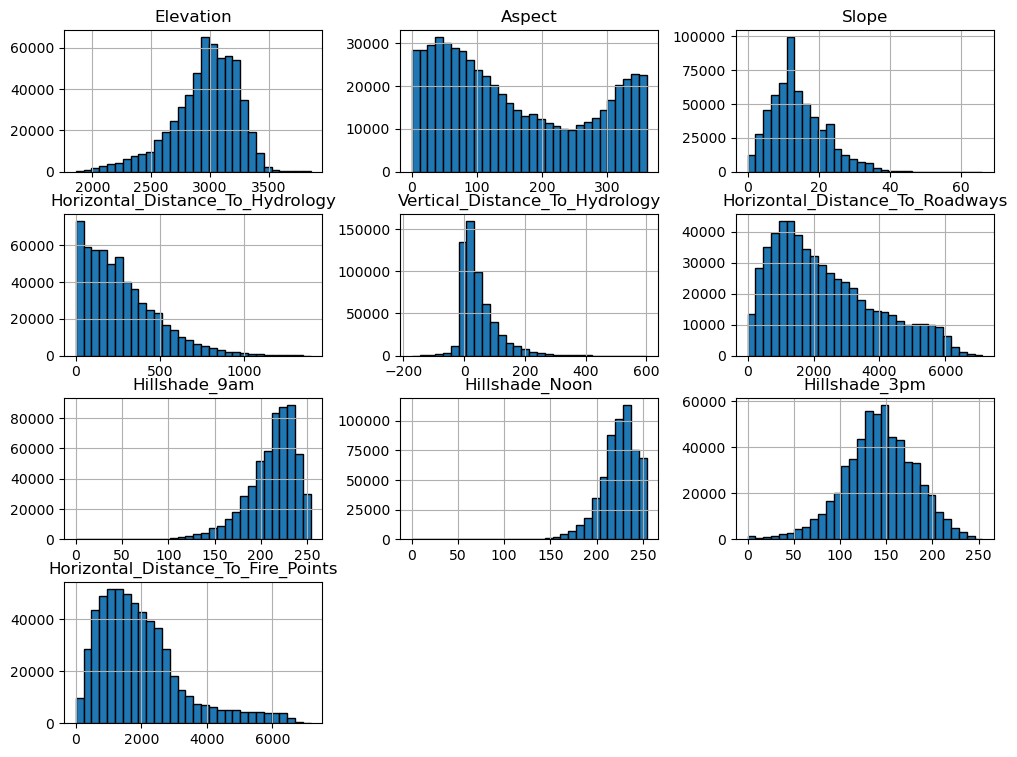

In [3]:
# Plot a histogram of the continuous variables, and the target variable
df_cont = df.drop(['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type'], axis=1)

# Plot histogram of all continuous variable
df_cont.hist(figsize=(12, 9), bins=30, edgecolor="black")

And a histogram of the target variable:

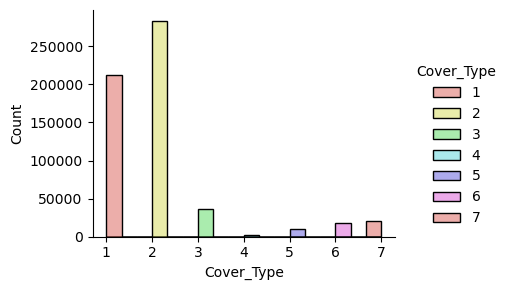

In [4]:
# Let's plot the cover type histogram again
sns.displot(data=df, x='Cover_Type', bins=18,
            height=3, aspect=1.4, hue='Cover_Type',
            palette='hls')

As you can see, there are many more instances of cover type 1 and 2. In my ML project, I used undersampling to balance the data and then ran 10 iterations, averaging the scores and presenting standard deviation between the runs. 

## 3 Layer MLP

Below I initialize a 3 layer MLP using PyTorch, and train and test over 10 epochs. 

In [5]:
# function to count number of parameters of a NN
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [19]:
# Create the feature dataset 
class FeatureDataset(Dataset):

    def __init__(self, file_name, target):

        # Separate into target variable and input data
        #x = df.drop(["Cover_Type"], axis=1).values
        #y = df["Cover_Type"].values 

        x = df.drop([target], axis=1).values
        y = df[target].values 

        # Normalize the labels, 7 classes of forest cover
        le = LabelEncoder()
        y = le.fit_transform(y)

        # Normalize x 
        sc = StandardScaler()
        x = sc.fit_transform(x) 
    
        # Convert to torch tensors 
        self.X_train = torch.tensor(x, dtype=torch.float32)
        self.y_train = torch.tensor(y)

    # Return the size of the dataset using the target variable 
    def __len__(self):
        return len(self.y_train)

    # Return the specific data point using the declared X_train and y_train variables
    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [7]:
# Three layer classifier 
class MLP(nn.Module):
    
    # initialize 
    def __init__(self, input_size, n_hidden, output_size):
        
        # call the super class MLP and get it's methods
        super(MLP, self).__init__()
        
        # define the input size 
        self.input_size = input_size
        
        # define the network (3 layer linear with relu activation, using softmax probs at the end)
        self.network = nn.Sequential( #sequential layers
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    # return the forward prop of the network
    def forward(self, x):
        return self.network(x)

In [8]:
# initialize accuracy list for use with test loop
accuracy_list = []
predictions = []

# train loop
def train(epoch, model):
    
    # make sure the model is on the device, in the case, the CPU
    model.to(device) 
    
    # initialize the optimizer - using ADAM here
    optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)
    
    # print the number of parameters in the model
    print('Number of parameters: {}'.format(get_n_params(mlp)))

    # initialize the training
    model.train()
    
    # for each batch in the training dataset
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device (in this case, CPU, because I'm using LabelEncoder and StandardScalar from Scikit Learn)
        # the data and model need to be on the same device
        data, target = data.to(device), target.to(device)
        
        # initialize the optimizer (ie. zero the grad)
        optimizer.zero_grad() # set the gradient of the optimizer
        
        # calculate the output for the batch 
        output = model(data)
        
        # calculate the loss 
        loss = F.nll_loss(output, target) # apply the loss function to it 
        
        # backward prop the loss
        loss.backward()
        
        # perform the parameter update based on the current gradient
        optimizer.step()
        
        # print statements for the training
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# test loop             
def test(model):
    
    # initialize model evaluation
    model.eval()

    # initialize test loss and correct variables 
    test_loss = 0
    correct = 0

    # for each test data and the corresponding target
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # calculate the output of the model 
        output = model(data)
        
        # sum up batch loss 
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        
        # get the index of the max log-probability 
        pred = output.data.max(1, keepdim=True)[1]
        
        # Sum the number of correct predictions 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    # calculate the loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    # print the loss and accuracy 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))


In [9]:
if __name__ == "__main__":
    
    # call the covtype csv file
    csv_file = "covtype.csv"

    # create a FeatureDataset object from the csv file, with a target variable called "Cover_Type
    feature_set = FeatureDataset(csv_file, "Cover_Type")
    
    # set batch size (this determines when the backwards prop of the loss occurs)
    batch_size = 100

    # Split into 80% training and 20% test randomly
    train_size = int(0.8 * len(feature_set))
    test_size = len(feature_set) - train_size
    trainset, testset = random_split(feature_set, [train_size, test_size])

    # pass into their own dataloaders 
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

    # Using CPU
    device = torch.device("cpu")
    print(device)

    # set the input size to number of columns minus target
    input_size = 54
    
    # hidden layer size in 3 layer MLP 
    n_hidden = 15
    
    # number of classes 
    output_size = 7
    
    # initialize the model as "mlp"
    mlp = MLP(input_size, n_hidden, output_size)

    print("Training and testing network with three layers")
    
    # pass the number of epochs and the model, and train and test 
    for epoch in range(0, 10):
        train(epoch, mlp)
        test(mlp)

cpu
Training and testing network with three layers
Number of parameters: 1177
Train Epoch: 0 [0/464809 (0%)]	Loss: 1.895160
Train Epoch: 0 [10000/464809 (2%)]	Loss: 1.096041
Train Epoch: 0 [20000/464809 (4%)]	Loss: 0.981592
Train Epoch: 0 [30000/464809 (6%)]	Loss: 0.833638
Train Epoch: 0 [40000/464809 (9%)]	Loss: 0.601457
Train Epoch: 0 [50000/464809 (11%)]	Loss: 0.604288
Train Epoch: 0 [60000/464809 (13%)]	Loss: 0.696675
Train Epoch: 0 [70000/464809 (15%)]	Loss: 0.585084
Train Epoch: 0 [80000/464809 (17%)]	Loss: 0.677324
Train Epoch: 0 [90000/464809 (19%)]	Loss: 0.562427
Train Epoch: 0 [100000/464809 (22%)]	Loss: 0.691221
Train Epoch: 0 [110000/464809 (24%)]	Loss: 0.638720
Train Epoch: 0 [120000/464809 (26%)]	Loss: 0.560403
Train Epoch: 0 [130000/464809 (28%)]	Loss: 0.581351
Train Epoch: 0 [140000/464809 (30%)]	Loss: 0.659858
Train Epoch: 0 [150000/464809 (32%)]	Loss: 0.601183
Train Epoch: 0 [160000/464809 (34%)]	Loss: 0.678710
Train Epoch: 0 [170000/464809 (37%)]	Loss: 0.680701
Train

Text(0.5, 1.0, '3 Layer MLP: Accuracy 78.29%')

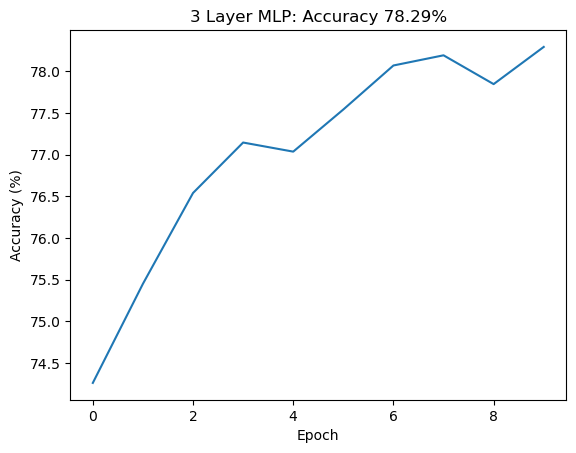

In [10]:
# Plot the training accuracy over all epochs
fig, ax = plt.subplots(1, 1)
sns.lineplot(data=accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('3 Layer MLP: Accuracy '+ str(round((accuracy_list[len(accuracy_list)-1]),2)) + '%')

### Comparison: 3 Layer MLP vs. SVM

The accuracy of the MLP trained using PyTorch was 78%. For my project, the accuracy of the ANN I trained was 73%, and the accuracy of the SVM was 82%, as seen in the tables below.

**The ANN was:**

MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20,50,20), 
                            max_iter=500, early_stopping=True, n_iter_no_change=5, 
                            validation_fraction=0.1, learning_rate='adaptive', random_state=42, alpha=0.1, tol=0.0001)
                            
**The SVM used was:**

clf_svm = SVC(decision_function_shape='ovr', kernel='rbf', gamma=0.1, C=5, tol=1, probability=True, break_ties=True)

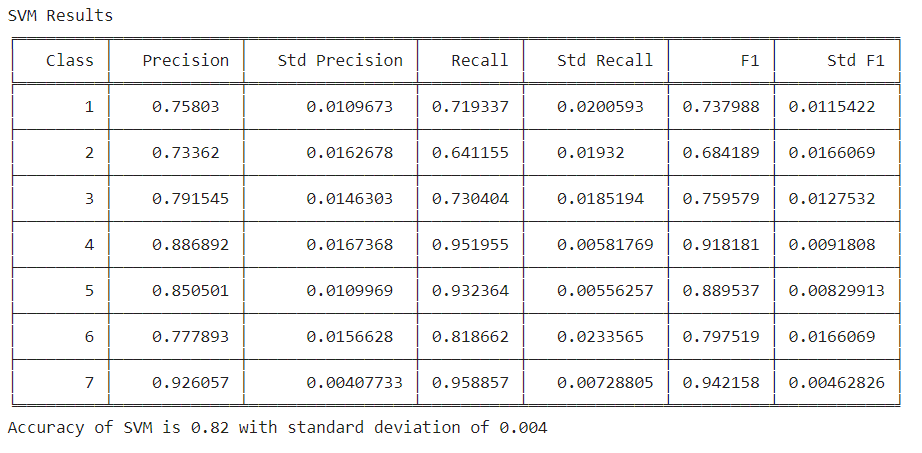

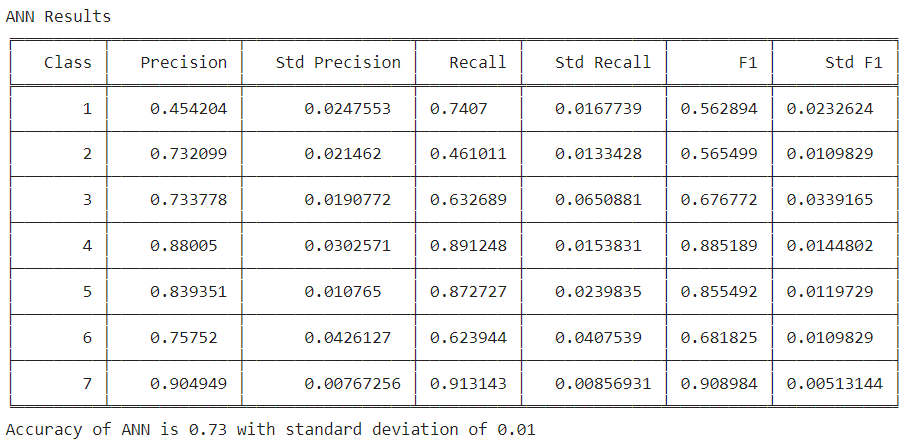

The MLP trained using PyTorch trained much faster than the ANN trained using Scikit learn. It achieved higher accuracy than the ANN trained using scikit learn, and lower accuracy than the SVM trained using scikit learn. The accuracy of the MLP trained with PyTorch could improve if a larger hidden layer size was used, or more hidden layers, or more training epochs and a smaller batch size. If I were designing this with more time, I would try many more combinations with well established architectures (such as ResNet-18) to see if the accuracy improved. PyTorch enables this as it is compatible with GPUs, whereas scikit learn is not. 

## Batch Normalization and Drop Out 3 Layer MLP

In [11]:
# No res connection, but with drop out and batch normalization
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size, dropout_rate):
        super(MLP, self).__init__()
        #super().__init__() # get all the features from the MLP class 
        self.input_size = input_size
        self.network = nn.Sequential( #sequential layers
            
            # linear w batch normalization and relu activation
            nn.Linear(input_size, n_hidden),
            # tabular data so use batch norm 1D
            nn.BatchNorm1d(n_hidden), 
            nn.ReLU(), 
            
            # linear layer w dropout at the dropout_rate, with relu activation
            nn.Dropout(p=dropout_rate),
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            
            # linear layer with softmax probabilities
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [12]:
mlp2 = MLP(input_size, n_hidden, output_size, dropout_rate=0.5)
    
for epoch in range(0,10):
    train(epoch, mlp2)
    test(mlp2)

Number of parameters: 1177
Train Epoch: 0 [0/464809 (0%)]	Loss: 1.972506
Train Epoch: 0 [10000/464809 (2%)]	Loss: 1.113644
Train Epoch: 0 [20000/464809 (4%)]	Loss: 1.153383
Train Epoch: 0 [30000/464809 (6%)]	Loss: 0.925303
Train Epoch: 0 [40000/464809 (9%)]	Loss: 0.923099
Train Epoch: 0 [50000/464809 (11%)]	Loss: 0.907884
Train Epoch: 0 [60000/464809 (13%)]	Loss: 0.846258
Train Epoch: 0 [70000/464809 (15%)]	Loss: 0.812343
Train Epoch: 0 [80000/464809 (17%)]	Loss: 0.858525
Train Epoch: 0 [90000/464809 (19%)]	Loss: 0.674829
Train Epoch: 0 [100000/464809 (22%)]	Loss: 0.732308
Train Epoch: 0 [110000/464809 (24%)]	Loss: 0.832635
Train Epoch: 0 [120000/464809 (26%)]	Loss: 0.843593
Train Epoch: 0 [130000/464809 (28%)]	Loss: 0.848379
Train Epoch: 0 [140000/464809 (30%)]	Loss: 0.816871
Train Epoch: 0 [150000/464809 (32%)]	Loss: 0.757467
Train Epoch: 0 [160000/464809 (34%)]	Loss: 0.717115
Train Epoch: 0 [170000/464809 (37%)]	Loss: 0.737953
Train Epoch: 0 [180000/464809 (39%)]	Loss: 0.726829
Trai

In [13]:
#print(len(accuracy_list))
#print(accuracy_list)
#print(epoch)

# Get the accuracy for just the second network - could have reinitialized the accuracy_list parameter too
acc2 = accuracy_list[10:20]
print(acc2)

[71.3225992444257, 71.43189074292403, 71.66596387356608, 71.76148636437958, 71.6220751615707, 71.99383836906104, 71.78902437974924, 71.73480891199023, 72.33290018329991, 70.00421675860348]


Text(0.5, 1.0, '3 Layer MLP: Accuracy 70.0%')

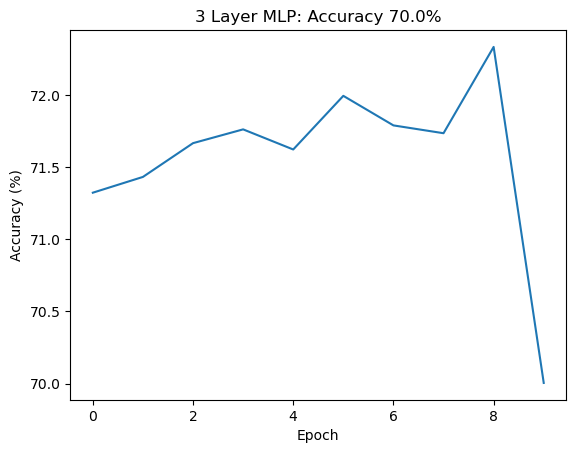

In [14]:
# Plot the training accuracy over all epochs
fig1, ax1 = plt.subplots(1, 1)
sns.lineplot(data=acc2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('3 Layer MLP: Accuracy '+ str(round((accuracy_list[len(accuracy_list)-1]),2)) + '%')

Dropout and batch normalization seemed to decrease the accuracy of the network. I would suspect that this is a result of dropout, not the batch normalization. Dropout randomly drops some connections and this is only a 3 layer MLP network, and so I suspect that every layer is important and using dropout is not appropriate with such a shallow network. The 3 layer MLP with dropout and batch normalization performed worse than the previous 3 layer PyTorch MLP, and both the ANN and SVM from my machine learning project.

## Conclusion

PyTorch is compatible with GPUs which makes it appropriate for deeper networks for complex tasks, rather than using scikit learn framework. In the case of the forest cover dataset, a 3 layer MLP classifier without dropout and batch normalization achieved an accuracy of 78%, and with dropout and batch normalization an accuracy of 70%. The network with dropout and batch normalization performed worse than the network without, and this could be because dropout with the selected rate is not appropriate for such a simple network. 

The ANN network trained with scikit learn performed worse than the 3 layer MLP implented here. The SVM trained with scikit learn outperformed both 3 layer MLPs trained here, but increasing the number of layers (or using a well established architecture such as ResNet-18) and training iterations could improve these percentages.

I attempted to implement a residual connection (seen below), but ran into an error, I think due to it being a multiclass problem. I will continue to look into this. 

## Residual Connection Attempt (Couldn't Figure it Out, Sad)

I think it's something to do with the multiclass classification - it said I can't add x back to the output of the network - most examples show something similar to the below, but it didn't work for me. :( 

In [15]:
# No res connection, but with drop out and batch normalization
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        # Adding residual connection from input to second layer
        out = self.fc2(out) + x # x dimension is wrong! can't add them like this, it's something to do with it being multiclass I think
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [16]:
#mlp2 = MLP2(input_size, n_hidden, output_size, dropout_rate=0.5)
mlpr = MLP(input_size, n_hidden, output_size)

#print("Training network with dropout and batch normalization")
#for epoch in range(0, 10):
#    train(epoch, mlp2) # train 
#    test(mlp2)
    
for epoch in range(0,10):
    train(epoch, mlpr)
    test(mlpr)

Number of parameters: 1177


RuntimeError: The size of tensor a (15) must match the size of tensor b (54) at non-singleton dimension 1

# References 

**Forest Cover Dataset:** https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset

**Creating a data loader for csv file data:** https://shashikachamod4u.medium.com/excel-csv-to-pytorch-dataset-def496b6bcc1